 # Chapter 53: Self-Organizing Maps

### This code generates figures 5, 6, 9, 11, and 12 in Chapter 53: Self-Organizing maps (vol. III)


Runs simulations for Examples 1 and 3 in the chapter

TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs.  The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 

</div>

The Jupyter notebook and python codes are developed by Saba Nasiri. 

required libraries:

1. numpy
2. numpy.matlib
3. matplotlib.pyplot
4. plotly.graph_objects
5. scipy.io
6. mpl_toolkits.mplot3d.axes3d
7. matplotlib.cm


In [1]:
import numpy as np
from numpy import matlib as mb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.io
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm


## Example 53.1 (Color matching)

We illustrate the operation of a SOM by considering a classical example that involves mapping three-dimensional RGB color coordinates (corresponding to the colors red, green, and blue) into locations in the plane. We consider a square grid consisting of $K_1=20$ neurons along each direction (vertical and horizontal) for a total of $K=400$ neurons. The training data consists of only $N=8$ feature vectors, each of size $3\times 1$ (i.e., $M=3$). Figure 53.4 lists the feature vectors, whose entries represent RGB coordinates in the range $0$ to $255$. Under each column, we place a colored circle to illustrate the color that the RGB entries in that column represent. For example, the first column has coordinates $(255,0,0)$ and  represents the color red. The SOM iterates over these feature vectors repeatedly and in a randomized manner. The feature vectors are not normalized in this example in order to retain the color mapping.

A total of $P=1000$ passes are performed over the training data. The entries of the $3\times 1$ weight vectors for each neuron in the grid are initialized to random integer values in the interval $[0,255]$. The parameters used to run recursion (53.28) are set to

$$
\mu=1,\;\;\bar{\mu}=0.1,\;\;P_o=100, \;\;\lambda=0.99,\;\;\;\alpha=0.995 \tag{53.31}
$$

with the initial value for the radius chosen as $R(1)=K=400$.  We plot in Fig. 53.5 two representations for the state of the SOM after  $1000$ passes. We focus on the map shown on the left side. This map transforms the weights of the neurons into colors. We also place on top of the map the initial feature vectors represented by the colored circles. Observe how the neuron locations around each feature vector have a similar color to the input vector. Observe also how the SOM generates clusters of color in the plane: It identifies regions where features are more red-like, and regions where the features are more green-like, and so forth. The other map on the right in the figure will be discussed in the next section. It is generated by constructing an enlarged  unified distance matrix, $U$, which is a matrix containing information about the distances between the weights of the neurons, i.e., quantities of the form $\|w_{k}-w_{\ell}\|$. The lighter color represents regions where neurons are close to each other in $w-$space, while the darker color represents transitions or barriers between these regions. 
Figure 53.6 shows a third representation, known as a terrain plot, which essentially plots the distance values in the $U-$matrix.  The bottom mesh plot in the figure illustrates how similar neurons are pulled together towards close weight values (i.e., small distances between them).


In [8]:
K1 = 20 # SOM with K1 x K1 nodes
K = K1 * K1 # Total number of nodes
a = [x for x in range(K)]
J , I = np.unravel_index(a, (K1,K1)) # The nodes are numbered 1 through K1 vertically: first column is 1:K1,
                                     # second column is K1+1:2K1, and so on
                                     # I is COLUMN index    (r,c) = (J,I)
                                     # J is ROW index
            
# generate data
# each row is a feature vector
DATA = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [0, 100, 255], [255, 150, 75], [150, 150, 0], [0, 255, 60], [255, 130, 255]]
DATA = np.array(DATA)
H = DATA.T # in this example we are not normalizing the data to maintain the color mapping
M = H.shape[0] # feature dimension
N = H.shape[1] # number of training features

W = np.fix(255*np.random.rand(M, K)) # initialization of weight vectors at all nodes; each column is a w
rho = K # decaying radius for neighborhoods; initial radius value (large enough)
alpha = 0.995 # rate of decay of rho

mu = 1 # decaying step-size; initial value
alpha_mu = 0.99 # rate of decay of mu
mu_bar = 0.1

number_of_passes = 1000 # number of passes over the data
Po = np.fix(0.1*number_of_passes) # about 10%


for p in range(number_of_passes):
    P = np.random.permutation(N)
    for n in range(N):
        h = H[:, P[n]] # feature vector is a column
        X = mb.repmat(h.reshape(-1, 1), 1, K) # repeats vector h a total of  K times
        aux = np.sqrt((W-X)**2)
        dist = np.sum(aux, 0) # a row vector containing the distances from h to all nodes in the grid
        idx = np.argsort(dist)[0] # index of winner node from the list 1 through K
        ro = J[idx] # row index of winning node
        co = I[idx] # column index of winning node
        
        s1 = mb.repmat([ro, co], K, 1) # repeats the winning indices K times; one row under the other
        s2 = np.sum((np.concatenate((I.reshape(1, -1).T, J.reshape(1, -1).T), axis = 1)-s1)**2, 1) # vector of squared distances between winning node and other nodes
        scale = (1/(np.sqrt(2*np.pi)*rho)) * np.exp(-s2/(2*rho**2)) # vector of scaling coefficients; Gaussian kernel applied to all nodes
        
        for k in range(K):
            w = W[:, k]
            wx = w + mu*scale[k]*(h-w)
            W[:, k] = wx
            
    if p <= Po:
        mu = mu * alpha_mu # otherwise step-size is not decreased anymore
    else:
        mu = mu_bar
    
    rho = rho * alpha

C = np.zeros((K1, K1, M)) # transforming into an RGB format
nx = np.max(W)
for d in range(K):
    r = J[d] # row index
    c = I[d] # column index
    C[r, c, :] = W[:, d] # transformed W into an RGB matrix (this is useful for the RGB example). 
    
    
C = np.absolute(C/nx) # values between 0 and 1


In [9]:
# Unified distance calculations, Clustering
# Rectangular grid
# The matrix U below contains the distances between nodes, as well as the average distances on the diagonal.

K2 = (2*K1)-1
U = np.zeros((K2+1, K2+1)) # almost twice as large as the K1xK1 grid because we insert cells between every pair of neurons

for r in range(1, K1+1):
    for c in range(1, K1+1):
        r1 = 2*r - 1 # row and column indexes within U
        c1 = 2*c - 1
        summ = 0
        NN = 0
        d = (r-1) + (c-1)*K1 + 1 #  map location (r,c) in the K1xK1 grid to linear index d in the range 1:K
        w = W[:, d-1] # its weight vector
        
        if c<K1 :
            d1 = (r-1) + c*K1 + 1 # neighbor to the right
            w1 = W[:, d1-1] # its weight vector
            summ = summ + np.linalg.norm(w-w1)
            NN = NN + 1
            U[r1, c1+1] = np.linalg.norm(w-w1)
        
        if r<K1 :
            d2 = r + (c-1)*K1 + 1 # neighbor above
            w2 = W[:, d2-1] # its weight vector
            summ = summ + np.linalg.norm(w-w2)
            NN = NN + 1
            U[r1+1, c1] = np.linalg.norm(w-w2)
        
        if c>1 :
            d3 = (r-1) + (c-2)*K1 + 1 # neighbor to left
            w3 = W[:, d3-1] # its weight vector
            summ = summ + np.linalg.norm(w-w3)
            NN = NN + 1
            U[r1, c1-1] = np.linalg.norm(w-w3)

        if r>1 :
            d4 = (r-2) + (c-1)*K1 + 1 # neighbor below
            w4 = W[:, d4-1] # its weight vector
            summ = summ + np.linalg.norm(w-w4)
            NN = NN + 1
            U[r1-1, c1] = np.linalg.norm(w-w4)
            
        U[r1, c1] = summ/NN # average
        
# let us fix the x entries of U, which we will set to the average of their
# neighbors as explained in the text       
U_opt2 = U # second option to construct U-matrix

for r in range(2,2*K1-2+1,2):
    for r in range(2,2*K1-2+1,2):
        a = U[r, c-1] + U[r, c+1] + U[r-1, c] + U[r+1, c]
        U_opt2[r, c] = a/4
        
ax = np.max(U_opt2)
U_opt2 = U_opt2/ax # normalize entries to the interval [0,1]

U_opt1 = np.zeros((K1+1, K1+1)) # first option to construct U-matrix

for r1 in range(1, K2+1, 2):
    for c1 in range(1, K2+1, 2):
        r = int((r1+1)/2)
        c = int((c1+1)/2)
        U_opt1[r, c] = U[r1, c1]
    
ax = np.max(U_opt1)
U_opt1 = U_opt1/ax # normalize entries to the interval [0,1]


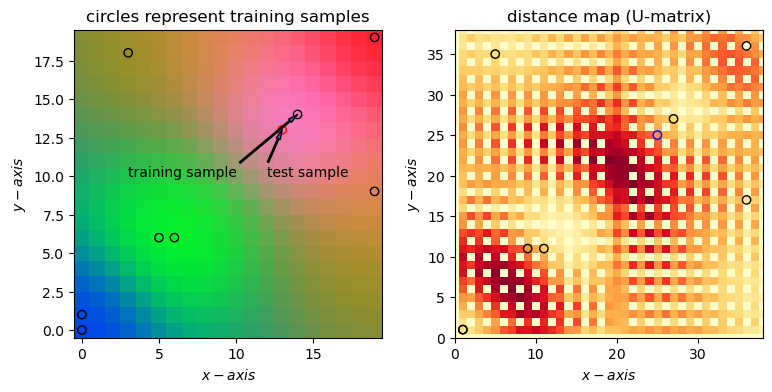

In [10]:
# figure 5 (color maps)

f1, axs1 = plt.subplots(1, 2, figsize=(9,4));
axs1[0].imshow(C);
axs1[0].set_ylabel("$y-axis$");
axs1[0].set_xlabel("$x-axis$");
axs1[0].set_title('circles represent training samples');
axs1[0].set_xlim(-0.5, 19.5)
axs1[0].set_ylim(-0.5, 19.5)

# plot training points
for n in range(N):
    h = (DATA[n, :]).T
    X = mb.repmat(h.reshape(-1, 1), 1, K) # repeats vector h a total of  K timess
    aux5 = np.sqrt((W-X)**2)
    dist5 = np.zeros((K,))
    for k in range(K):
        dist5[k] = np.linalg.norm(aux5[:,k]) # a row vector containing the distances from h to all nodes in the grid

    idx5 = np.argsort(dist5)[0] # index of winner node from the list 1 through K
    ro = J[idx5] # row index of winning node
    co = I[idx5] # column index of winning node
    axs1[0].scatter(co, ro, facecolors='none', edgecolors='black')
    
co2 = co
ro2 = ro

# plotting the test vector

h = np.array([164, 168, 250])
X = mb.repmat(h.reshape(-1, 1), 1, K) # repeats vector h a total of  K timess
aux7 = np.sqrt((W-X)**2)
dist7 = np.zeros((K,))
for k in range(K):
    dist7[k] = np.linalg.norm(aux7[:,k]) # a row vector containing the distances from h to all nodes in the grid

idx7 = np.argsort(dist7)[0] # index of winner node from the list 1 through K
ro = J[idx7] # row index of winning node
co = I[idx7] # column index of winning nodeplot(co,ro,'s', 'MarkerFaceColor',[h(1)/255 h(2)/255 h(3)/255],'MarkerSize',20,'MarkerEdgeColor','k');
axs1[0].scatter(co, ro, facecolors='none', edgecolors='r')

axs1[0].annotate("training sample",xy=(co2, ro2),xytext=(3,10),arrowprops={"width":1,"headwidth":3,'headlength':7});
axs1[0].annotate("test sample",xy=(co, ro),xytext=(12,10),arrowprops={"width":1,"headwidth":3,'headlength':7});

# figure 5 (part of the same figure; colormpas)
axs1[1].imshow(U_opt2, cmap='YlOrRd')
axs1[1].set_xlim(0, 38)
axs1[1].set_ylim(0, 38)
axs1[1].set_ylabel("$y-axis$");
axs1[1].set_xlabel("$x-axis$");
axs1[1].set_title('distance map (U-matrix)');

co = 2*co -1
ro = 2*ro -1
if co >= 37:
    co = 36
if ro >= 37:
    ro = 36
if co <= 0:
    co = 1
if ro <= 0:
    ro = 1
    
axs1[1].scatter(co, ro, facecolors='none', edgecolors='blue')

#  plot training points

for n in range(N):
    h = (DATA[n, :]).T
    X = mb.repmat(h.reshape(-1, 1), 1, K) # repeats vector h a total of  K timess
    aux4 = np.sqrt((W-X)**2)
    dist4 = np.zeros((K,))
    for k in range(K):
        dist4[k] = np.linalg.norm(aux4[:,k]) # a row vector containing the distances from h to all nodes in the grid

    idx4 = np.argsort(dist4)[0] # index of winner node from the list 1 through K
    ro = J[idx4] # row index of winning node
    co = I[idx4] # column index of winning node
    co = 2*co -1
    ro = 2*ro -1
    if co >= 37:
        co = 36
    if ro >= 37:
        ro = 36
    if co <= 0:
        co = 1
    if ro <= 0:
        ro = 1
    axs1[1].scatter(co, ro, facecolors='none', edgecolors='black')
    

# plt.savefig('fig 53.5.pdf')

**Figure 53.5** Color map representation of the weight vectors across the rectangular arrangement for the SOM after $P=1000$ passes over the data. Distance map ($U-$ matrix) generated according to the description in the next section.

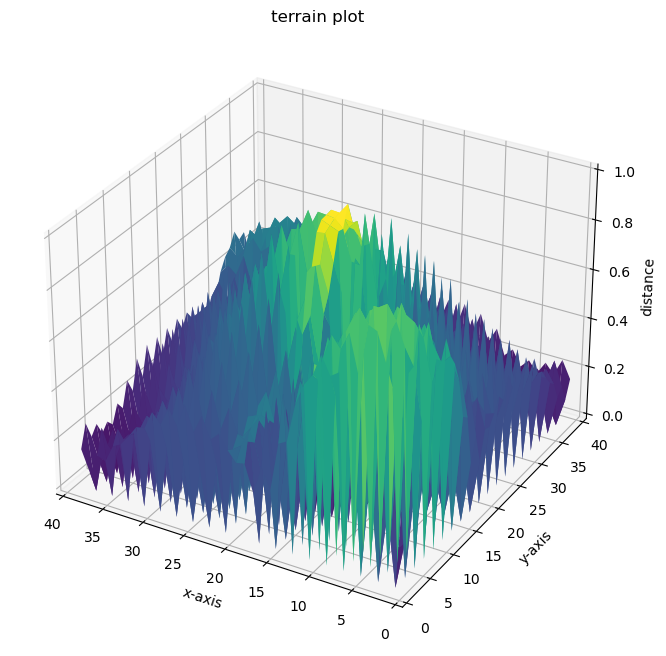

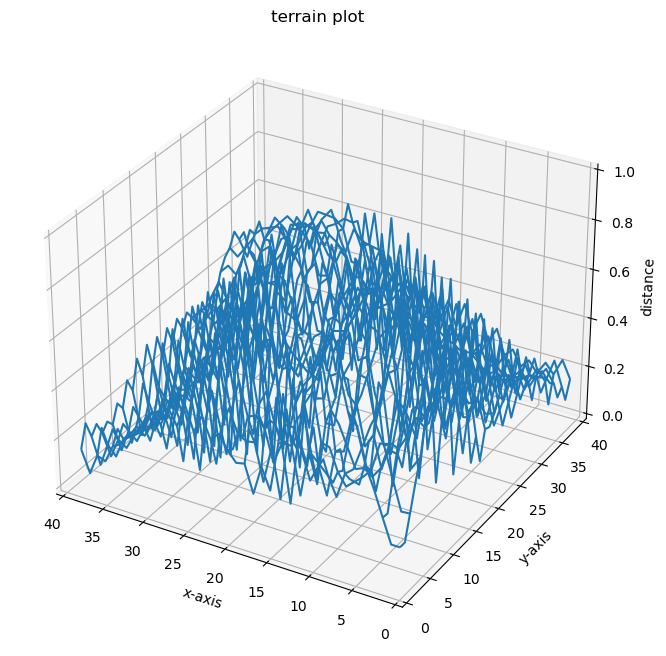

<Figure size 640x480 with 0 Axes>

In [11]:
# figure 6 (terrain maps)

fig = plt.figure(figsize =(8, 8))
ax = plt.axes(projection ='3d')
a1 = np.arange(0, K2)
a2 = np.arange(0, K2)
x, y = np.meshgrid(a1, a2)
ax.plot_surface(x, y, U_opt2[1:, 1:], cmap=cm.viridis);
ax.set_title("terrain plot");
ax.set_xlabel("x-axis");
ax.set_ylabel("y-axis");
ax.set_zlabel("distance");
ax.set_xlim(40, 0);
ax.set_ylim(0, 40);


fig = plt.figure(figsize =(8, 8))
wf = fig.add_subplot(111, projection='3d')
wf.plot_wireframe(x, y, U_opt2[1:, 1:], rstride=2, cstride=2, cmap=cm.viridis)
wf.set_xlabel("x-axis");
wf.set_ylabel("y-axis");
wf.set_zlabel("distance");
wf.set_title("terrain plot")
wf.set_xlim(40, 0);
wf.set_ylim(0, 40);

plt.show()

plt.savefig('fig 53.6.pdf')

**Figure 53.6** Terrain maps generated according to the description in the next section. The bottom mesh  illustrates how similar neurons are pulled together towards close weight values (i.e., small distances between them).



Once the SOM is trained, we can employ it for classification as follows. Assume  a feature vector $h$  is received and we desire to identify what color it corresponds to. In the simulation we used $h=\text{col}\{164,168,250\}$.  This test vector is mapped to the location of the neuron whose weight vector is closest to $h$. This is indicated by the square marker in the map on the left of Fig. 53.5. The SOM ends up "recognizing" the color of $h$, or at least the cluster that is most representative of its color. Observe how $h$ is mapped to a location in the grid of similar color. 



Once the $U-$ matrix is constructed, we generate a gray-scale representation for it where smaller entries appear in light color and larger entries appear in dark color --- see Fig. 53.9. The result is a color map that helps visualize clusters in the data. This construction was illustrated in the plot on the right in Fig. 53.9 for the earlier example using a different color scheme for illustration purposes. A comparison between both constructions for the $U-$matrix for the same example is shown in Fig. 53.9, again using a different color scheme than gray-scale. 

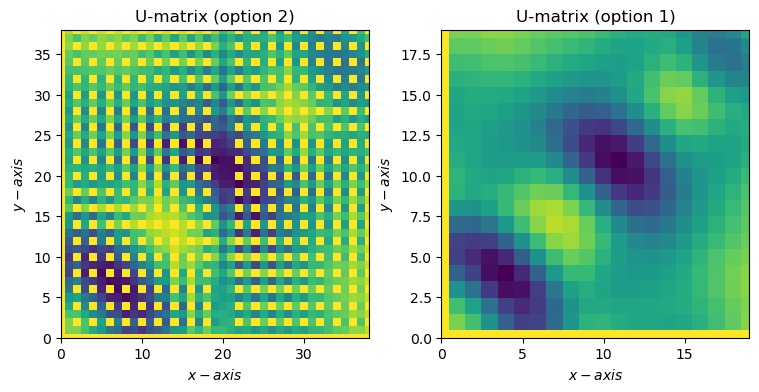

In [12]:
# figure 9 (colormaps)

f1, axs1 = plt.subplots(1, 2, figsize=(9,4));
axs1[0].imshow(1-U_opt2, cmap='viridis')
axs1[0].set_xlim(0, 38)
axs1[0].set_ylim(0, 38)
axs1[0].set_ylabel("$y-axis$");
axs1[0].set_xlabel("$x-axis$");
axs1[0].set_title('U-matrix (option 2)');

axs1[1].imshow(1-U_opt1, cmap='viridis')
axs1[1].set_xlim(0, 19)
axs1[1].set_ylim(0, 19)
axs1[1].set_ylabel("$y-axis$");
axs1[1].set_xlabel("$x-axis$");
axs1[1].set_title('U-matrix (option 1)');

plt.savefig('fig 53.9.pdf')

**Figure 53.9** Comparison between the two constructions for the $U-$ matrix for the simulation under Example 53.1.


## EXAMPLE 53.33 (Application to breast cancer dataset)

We apply the SOM formulation to a breast cancer dataset.
The data consists of $N=569$ samples $\{h_n\}$, with each sample corresponding to a benign or malignant cancer classification. We use $\gamma(n)=-1$ for benign samples and $\gamma(n)=+1$ for malignant samples. Each feature vector in the data contains $M=30$ attributes corresponding to measurements extracted from a digitized image of a 
fine needle aspirate (FNA) of a breast mass. The attributes describe characteristics of the cell nuclei present in the image, such as those listed in 
Table 53.1. The feature vectors are normalized by following construction (53.3).
 
**Table 53.1** Attributes for the breast cancer dataset.
<table style="width: 70%;">
    <tr>
    <th>Attribute</th>
    <th>Explanation</th>
     </tr>
  <tr>
    <th>1</th>
    <th> Radius of the cell, measured in terms of the mean of the distances from the center of the cell to points on the perimeter. </th>
    </tr>
  <tr>
    <th>2</th>
    <th>Texture of the cell, measured in terms of the standard deviation of the grayscale values.
      </th>
    </tr>
    
    
   <tr>
    <th>3</th>
    <th>Perimeter of the cell. 
      </th>
    </tr>
    
  <tr>
    <th>4</th>
    <th>Perimeter of the cell. 
      </th>
    </tr>
    
    
  <tr>
    <th>5</th>
    <th>Smoothness of the cell, measured in terms of local variation in radius lengths.
      </th>
    </tr>
    
    
  <tr>
    <th>6</th>
    <th>Compactness of the cell, measured in terms of $\mbox{perimeter}^2/\mbox{area} - 1.0$.
      </th>
    </tr>
    
    
  <tr>
    <th>7</th>
    <th>Concavity, measured in terms of the severity of the concave portions of the cell contour.
      </th>
    </tr>
    
    
  <tr>
    <th>8</th>
    <th>Number of concave portions of the cell contour.
      </th>
    </tr>
    
    
  <tr>
    <th>9</th>
    <th>Cell symmetry.
      </th>
    </tr>
  <tr>
      
   <th>10</th>
    <th>Fractal dimension, measured in terms of a "coastline approximation" minus one.
      </th>
    </tr>
  
</table>
<br>
 
 

We select $456$ samples ($80\%$) for training the SOM and retain the other $113$ samples ($20\%$) for testing the classification performance.  A total of $P=1000$ passes are performed over the training data. The entries of the weight vectors for each neuron in the grid are initialized to random Gaussian values with zero mean and unit variance.  The parameters used to run recursion (53.28) over a $50\times 50$ square grid are set to

$$
\mu=1,\;\;\bar{\mu}=0.1,\;\;P_o=100, \;\;\lambda=0.99,\;\;\;\alpha =0.99 \tag{53.41}
$$

with the initial value for the radius variable chosen as $R(1)=K=2500=(50)^2$.  Once the SOM is trained, we end up with weight vectors $\{w_k\}$ for each neuron in the grid. For each training feature vector $h_n$, we find the closest neuron and place either a green or red circle at its location, depending on whether $h_n$ belongs to  class $\gamma(n)=-1$ (benign sample) or $\gamma(n)=+1$ (malignant sample); if multiple training feature vectors $\{h_n\}$ end up mapping to the same location in the grid, we use a majority vote to decide on the label for that location. The resulting plot is shown in  Fig. 53.11, which illustrates the clustering ability of the SOM. 
 
 
We use the SOM for classification as follows. Figure 53.12 shows four plots. The top leftmost plot repeats the mapping of the training feature vectors from Fig. 53.11 for comparison with the other three plots. In this plot, the colored symbols are only placed at the locations corresponding to the features $\{h_n\}$. In the plot below it, we extend the label assignments to all neural locations in the grid to generate a $class$ $map$ as follows. For each neuron, we determine the closest five training feature vectors and assign their majority label to the neuron. By doing so, we obtain two colored regions. During testing, feature vectors $h$ falling into one region or the other will be classified accordingly as belonging to class $\gamma=+1$ or $\gamma=-1$. The rightmost plot in the bottom row displays the locations of the test samples on the grid (they are placed at the locations of the closest neurons).  The rightmost plot in the first row shows the result of classifying these test samples by using the SOM, where each test sample is assigned the label of the closest neuron. This construction leads to $5$ errors out of $113$ test samples, which corresponds to an empirical error rate on the order of $4.42\%$.
 
 

In [ ]:
data = scipy.io.loadmat('./data/breast_cancer_data_normalized.mat')
Ap = data['Ap']
labelsp = data['labelsp']
N = Ap.shape[0]
M = Ap.shape[1]

N_test = np.fix(0.2 * N)
features_test = Ap[int(N-N_test+1):N,:]
labels_test = labelsp[int(N-N_test+1):N]
features_train = Ap[0:int(N-N_test)+1,:]
labels_train = labelsp[0:int(N-N_test+1)+1]
number_of_classes = 2

number_of_passes = 1000 # number of passes over the data
K1 = 50 # SOM with K1 x K1 nodes

K = K1 * K1 # Total number of nodes
a = [x for x in range(K)]
J , I = np.unravel_index(a, (K1,K1)) # The nodes are numbered 1 through K1 vertically: first column is 1:K1,
                                     # second column is K1+1:2K1, and so on
                                     # I is COLUMN index   (r,c) = (J,I)
                                     # J is ROW index

H = features_train.T # each column is a feature vector
M = H.shape[0]
NT = H.shape[1] # training data

W = np.random.rand(M, K) # initialization of weight vectors at all nodes; each column is a w
rho = K # decaying radius for neighborhoods; initial radius value (large enough)
alpha = 0.99 # rate of decay of rho

mu = 1 # decaying step-size; initial value
alpha_mu = 0.99 # rate of decay of mu
mu_bar = 0.1
number_of_passes = 1000
Po = np.fix(0.1*number_of_passes) # about 10% of total number of passes

for p in range(number_of_passes):
    if p == 1:
        print(p)
        
    if p%50 == 0:
        print(p)
        
    P = np.random.permutation(NT)
    for n in range(NT):
        h = H[:, P[n]] # feature vector is a column
        X = mb.repmat(h.reshape(-1, 1), 1, K) # repeats vector h a total of  K times
        aux = np.sqrt((W-X)**2)
        dist = np.sum(aux, 0) # a row vector containing the distances from h to all nodes in the grid
        idx = np.argsort(dist)[0] # index of winner node from the list 1 through K
        ro = J[idx] # row index of winning node
        co = I[idx] # column index of winning node
        
        s1 = mb.repmat([ro, co], K, 1) # repeats the winning indices K times; one row under the other
        s2 = np.sum((np.concatenate((I.reshape(1, -1).T, J.reshape(1, -1).T), axis = 1)-s1)**2, 1) # vector of squared distances between winning node and other nodes
        scale = (1/(np.sqrt(2*np.pi)*rho)) * np.exp(-s2/(2*rho**2)) 
        
        for k in range(K):
            w = W[:, k]
            wx = w + mu*scale[k]*(h-w)
            W[:, k] = wx
            
    if p <= Po:
        mu = mu * alpha_mu # otherwise step-size is not decreased anymore
    else:
        mu = mu_bar
    # updated after each pass on the data.
    rho = rho * alpha

            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


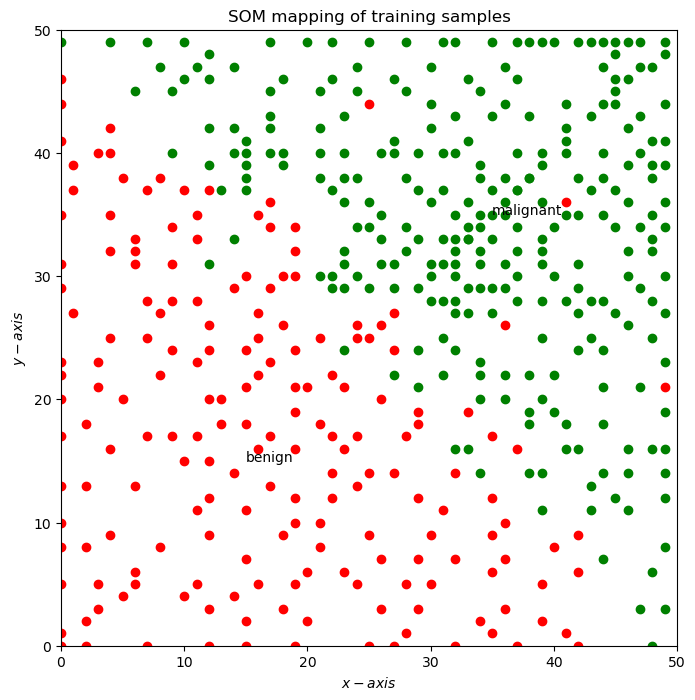

In [14]:
# figure 11 (scatter diagram)

C = 255 * np.ones((K1, K1, 3)) # just a grid to place the training points on

f1, axs1 = plt.subplots(1, 1, figsize=(8,8));
axs1.imshow(C)

axs1.set_ylabel("$y-axis$");
axs1.set_xlabel("$x-axis$");
axs1.set_title('SOM mapping of training samples');

for n in range(NT):
    h = H[:, n] # training feature vector is a column
    X = mb.repmat(h.reshape(-1, 1), 1, K) # repeats vector h a total of  K times
    aux2 = np.sqrt((W-X)**2)
    dist2 = np.zeros((K,))
    for k in range(K):
        dist2[k] = np.linalg.norm(aux2[:,k]) # a row vector containing the distances from h to all nodes in the grid

    idx2 = np.argsort(dist2)[0] # index of winner node from the list 1 through K
    ro = J[idx2] # row index of winning node
    co = I[idx2] # column index of winning node
    
    label = labels_train[n]
    if label == -1:
        axs1.scatter(co, ro, c='green')
        
    else:
        axs1.scatter(co, ro, c='red')
        
axs1.set_xlim(0, 50)
axs1.set_ylim(0, 50)
axs1.annotate("benign", xy = (10, 10), xytext=(15, 15), xycoords='data')
axs1.annotate("malignant", xy = (30, 30), xytext=(35, 35), xycoords='data')

plt.savefig('fig 53.11.pdf')

**Figure 53.11** Each feature vector $h_n$ from the training set is represented by a filled red or green circle (depending on its label: green for $\gamma(n)=-1$ and red for $\gamma=+1$) at the location of the neuron with the closest weight vector. Observe how  feature vectors corresponding to benign samples appear on one side of the plot, while all other feature vectors corresponding to the malignant samples appear on the other side of the plot. The original breast cancer dataset is available from https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic) and https://github.com/kostasdiamantaras/Machine-Learning-Example-MATLAB.
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


emperical error on test data : 
5.357142857142857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


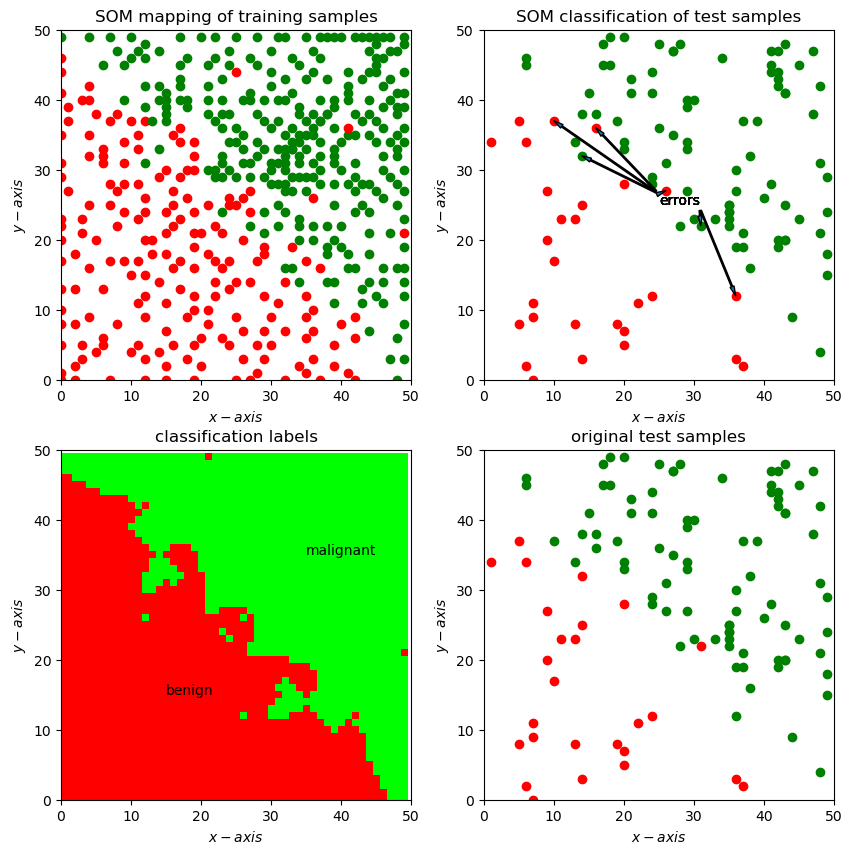

In [15]:
C = 255 * np.ones((K1, K1, 3))

f1, axs1 = plt.subplots(2, 2, figsize=(10,10));
axs1[0][0].imshow(C)

axs1[0][0].set_ylabel("$y-axis$");
axs1[0][0].set_xlabel("$x-axis$");
axs1[0][0].set_title('SOM mapping of training samples');
axs1[0][0].set_xlim(0, 50)
axs1[0][0].set_ylim(0, 50)

for n in range(NT):
    h = H[:, n]
    X = mb.repmat(h.reshape(-1, 1), 1, K)
    aux2 = np.sqrt((W-X)**2)
    dist2 = np.zeros((K,))
    for k in range(K):
        dist2[k] = np.linalg.norm(aux2[:,k])

    idx2 = np.argsort(dist2)[0]
    ro = J[idx2]
    co = I[idx2]
    
    label = labels_train[n]
    if label == -1:
        axs1[0][0].scatter(co, ro, c='green')
        
    else:
        axs1[0][0].scatter(co, ro, c='red')
        
        
neighbors = 5
label_neuron = np.ones((K, ))
for k in range(K):
    w = W[:, k]
    Wr = mb.repmat(w.reshape(-1, 1), 1, NT)
    aux9 = np.sqrt((Wr-H)**2)
    dist9 = np.zeros((NT,))
    for n in range(NT):
        dist9[n] = np.linalg.norm(aux9[:,n])
    
    idist = np.argsort(dist9)
    class_counter = np.zeros((number_of_classes,))
    for nn in range(neighbors):
        lab = labels_train[idist[nn]]
        if lab == -1:
            class_counter[0] = class_counter[0] + 1
        else:
            class_counter[1] = class_counter[1] + 1
            
    aidx = np.argmax(class_counter)
    if aidx == 0:
        label_neuron[k] = -1
     
    
axs1[0][1].imshow(C)

axs1[0][1].set_ylabel("$y-axis$");
axs1[0][1].set_xlabel("$x-axis$");
axs1[0][1].set_title('SOM classification of test samples');
axs1[0][1].set_xlim(0, 50)
axs1[0][1].set_ylim(0, 50)

H_test = features_test.T
error = 0
a = 0
#b = 0
for n in range(int(N_test)-1):
    h = H_test[:, n]
    X = mb.repmat(h.reshape(-1, 1), 1, K)
    aux20 = np.sqrt((W-X)**2)
    dist20 = np.zeros((K,))
    for k in range(K):
        dist20[k] = np.linalg.norm(aux20[:,k])

    idx20 = np.argsort(dist20)[0]
    labelT = label_neuron[idx20]
    a = 0
    if labelT != labels_test[n][0]:
        error = error + 1
        a = 1
        
    ro = J[idx20]
    co = I[idx20]
    
    if labelT == -1:
        axs1[0][1].scatter(co, ro, c='green')
        
    else:
        axs1[0][1].scatter(co, ro, c='red')
        
        
    if a == 1:
        #b = b + 1
        axs1[0][1].annotate("errors", xy = (co, ro), xytext=(25, 25), arrowprops={"width":1,"headwidth":3,'headlength':7})

        
print("emperical error on test data : ")
print(100*error/(N_test-1))

axs1[1][1].imshow(C)
axs1[1][1].set_ylabel("$y-axis$");
axs1[1][1].set_xlabel("$x-axis$");
axs1[1][1].set_title('original test samples');
axs1[1][1].set_xlim(0, 50)
axs1[1][1].set_ylim(0, 50)

H_test = features_test.T

for n in range(int(N_test)-1):
    h = H_test[:, n]
    X = mb.repmat(h.reshape(-1, 1), 1, K)
    aux20 = np.sqrt((W-X)**2)
    dist20 = np.zeros((K,))
    for k in range(K):
        dist20[k] = np.linalg.norm(aux20[:,k])

    idx20 = np.argsort(dist20)[0]
    label = labels_test[n]
    
        
    ro = J[idx20]
    co = I[idx20]
    
    if label == -1:
        axs1[1][1].scatter(co, ro, c='green')
        
    else:
        axs1[1][1].scatter(co, ro, c='red')
        
        
        
C = 255 * np.ones((K1, K1, 3))

for r in range(1,K1+1):
    for c in range(1,K1+1):
        k = (r-1) + (c-1)*K1 + 1
        if label_neuron[k-1] == -1:
            C[c-1, r-1, :] = [0, 255, 0]
        else:
            C[c-1, r-1, :] = [255, 0, 0]

            
            
axs1[1][0].imshow(C)
axs1[1][0].set_ylabel("$y-axis$");
axs1[1][0].set_xlabel("$x-axis$");
axs1[1][0].set_title('classification labels');
axs1[1][0].set_xlim(0, 50)
axs1[1][0].set_ylim(0, 50)
axs1[1][0].annotate("benign", xy = (10, 10), xytext=(15, 15), xycoords='data')
axs1[1][0].annotate("malignant", xy = (30, 30), xytext=(35, 35), xycoords='data')

plt.savefig('fig 53.12.pdf')

**Figure 53.12** The top leftmost plot maps the training samples to the closest neural locations in the SOM grid. The plot on the left in the bottom row assigns labels to each neural location by using the majority label of the five closest feature vectors in the training set. In the rightmost plot in the bottom row, each test sample is mapped to the closest neuron. The rightmost plot in the first row shows the result of classifying these test samples by using the SOM grid. 
